# ST449 - Artificial Intelligence and Deep Learning



---

## Instructions:



## P1. MNIST classification using multi-class logistic regression 

Consider a L2-regularized multi-class logistic regression model using the MNIST dataset. 

The model is given by
$\hat{y}=\sigma(W^TX+\mathbf{b})$, where $\sigma(\cdot)$ is 
the softmax function 
$$\sigma_j(x) = \frac{e^{z_j}}{\sum_{k=1}^{K}e^{z_k}}$$

The objective is the cross-entropy loss function:

$$l(\hat{y},y)=-\sum_{k=1}^{K}y_k\log(\hat{y_k})$$

where $K$ is the number of classes and $\hat{y_{k}}$ is the output probability that a sample belongs to class k, with a L2 regularizer on the weight parameters $W$, i.e., $\lambda||W||_2^2$, the L2 norm of the vectorized $W$ where $\lambda$ is a hyper-parameter. 

The hyper-parameter settings are given as below:
- minibatch size = 128 
- starting learning rate $\eta^{(0)}=0.001$
- decaying learning rate $\eta^{(t)}=\eta^{(0)}/\sqrt{t}$ during training where $t$ is the number of epochs 
- Momentum = 0.7
- $\lambda=0.01$
- total number of epoches = 45

**Task:** Evaluate and plot **the average loss per epoch** versus the number of epochs for the training dataset, for the following optimization algorithms:
- Mini-batch gradient descent
- Mini-batch AdaGrad
- Mini-batch gradient descent with Nesterov’s momentum
- Mini-batch Adam 

Discuss how the performance of different optimization algorithms compare to each other.


**Tensorflow Version 2.1 or 2.2 required**

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
# Parameters P1
batch_size_p1       = 128
learning_rate_p1    = 0.001
momentum_p1         = 0.7
L2_lambda_p1        = 0.01
epochs_p1           = 45

def decaying_learning_rate(epoch):
    return learning_rate_p1/np.sqrt(epoch)

In [3]:
# Load MNIST Data
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#x_train = tf.cast(x_train, tf.int32, name=None)
#y_train = tf.cast(y_train, tf.int32, name=None)
#x_test = tf.cast(x_test, tf.int32, name=None)
#y_test = tf.cast(y_test, tf.int32, name=None)

In [4]:
# Reformatting classifiaction from value 1-10 to one-hot encoded vector 
y_train = tf.one_hot(y_train, depth = 10)
y_test  = tf.one_hot(y_test , depth = 10)

# Reshaping y data so that y_hat and y data have the same dimensions 
y_train = tf.reshape(y_train, (y_train.shape[0], 1, y_train.shape[1]))
y_test  = tf.reshape(y_test,  (y_test.shape[0] , 1, y_test.shape[1] ))

# Normalising the x data
x_train = x_train.astype('float32') / 255.0 
x_test  = x_test.astype('float32') / 255.0

# Reformatting x data into tensor objects
x_train = tf.cast(x_train, tf.float32)
x_test  = tf.cast(x_test, tf.float32)

# Reshaping the x data from 28x28 matrix --> 784x1 vector
x_train = tf.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1] * x_train.shape[2]))
x_test  = tf.reshape(x_test,  (x_test.shape[0] , 1, x_test.shape[1]  * x_test.shape[2] ))

# Splitting data into batches
x_train_b = list(tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size_p1, drop_remainder=True))
y_train_b = list(tf.data.Dataset.from_tensor_slices(y_train).batch(batch_size_p1, drop_remainder=True))
x_test_b  = list(tf.data.Dataset.from_tensor_slices(x_test).batch(batch_size_p1 , drop_remainder=True))
y_test_b  = list(tf.data.Dataset.from_tensor_slices(y_test).batch(batch_size_p1 , drop_remainder=True))

2021-10-12 02:02:15.283755: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-10-12 02:02:15.306805: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fbdf04a76b0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-10-12 02:02:15.306823: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [5]:
# Defining relevent dimensions
x_dim = x_test.shape[2]
y_dim = y_test.shape[2]

# Initialise weight and bias variables
def initialise_variables():
    W = tf.Variable(tf.ones([x_dim, y_dim]), name = "W")
    b = tf.Variable(tf.ones([y_dim])       , name = "b")
    return W, b

In [6]:
# Logistic regression model 
def lr_model(x):
    y = tf.nn.softmax(tf.matmul(x, W) + b)
    return y

# Finds the average of a list
def average_lst(x):
    total  = sum(x)
    divsor = len(x)
    return total/divsor 

In [7]:
# Function that Trains & Evaluates the average training loss per epoch
def run(optimiser = "Adam"):
    loss_list = []
    
    print('Training starts on:', optimiser, "...")
    for epoch in range(epochs_p1):
        print("Epoch: ", str(epoch + 1))
        learning_rate = decaying_learning_rate(epoch + 1) # learning rate is updated for each epoch
        lst = []

        if optimiser == "Adam":
            optimiser = tf.optimizers.Adam(learning_rate = learning_rate)
        elif optimiser == "SGD":
            optimiser = tf.optimizers.SGD(learning_rate = learning_rate)
        elif optimiser == "AdaGrad":
            optimiser = tf.optimizers.Adagrad(learning_rate = learning_rate)
        else:
            optimiser = tf.optimizers.SGD(learning_rate = learning_rate, momentum=momentum_p1)
        
        for batch in range(len(x_train_b)):
            # Cross Entropy loss with L2 regulisation
            with tf.GradientTape(persistent=True) as tape:
                y_hat = lr_model(x_train_b[batch])
                loss  = -1* tf.math.reduce_sum( tf.matmul(y_train_b[batch], tf.math.log(y_hat), transpose_b = True))+ (L2_lambda_p1 * tf.math.reduce_sum(W**2))
            
            grads = tape.gradient(loss, [W, b])
            optimiser.apply_gradients(zip(grads, [W, b]))
            
            lst.append(loss)
            
        ave_loss = average_lst(lst)
        #print("Average Loss: ", str(int(ave_loss)))
        loss_list.append(ave_loss)
        
    return loss_list

In [8]:
W, b          = initialise_variables()
SGD           = run(optimiser="SGD")
########################################
W, b          = initialise_variables()
AdaGrad      = run(optimiser="AdaGrad")
#######################################
W, b          = initialise_variables()
SGD_Nesterov = run(optimiser="SGD_Nesterov")
#######################################
W, b          = initialise_variables()
Adam         = run(optimiser="Adam")

Training starts on: SGD ...
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Epoch:  32
Epoch:  33
Epoch:  34
Epoch:  35
Epoch:  36
Epoch:  37
Epoch:  38
Epoch:  39
Epoch:  40
Epoch:  41
Epoch:  42
Epoch:  43
Epoch:  44
Epoch:  45
Training starts on: AdaGrad ...
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Epoch:  32
Epoch:  33
Epoch:  34
Epoch:  35
Epoch:  36
Epoch:  37
Epoch:  38
Epoch:  39
Epoch:  40
Epoch:  41
Epoch:  42
E

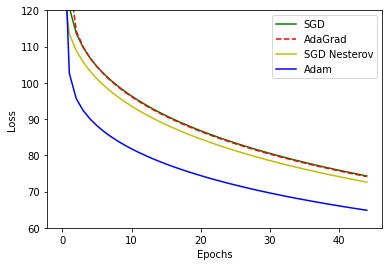

In [10]:
SGD_plt,          = plt.plot(SGD         , color = "g")
AdaGrad_plt,      = plt.plot(AdaGrad     , color = "r", linestyle = "dashed")
SGD_Nesterov_plt, = plt.plot(SGD_Nesterov, color = "y")
Adam_plt,         = plt.plot(Adam        , color = "b")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend([SGD_plt, AdaGrad_plt, SGD_Nesterov_plt, Adam_plt], ["SGD", "AdaGrad", "SGD Nesterov", "Adam"])
plt.ylim(60,120)
plt.show()

---
---

Comparison between optimisation algorithms:

---
---

The above graph indicates that the AdaGrad and Stocastic Gradient Decent (SGD) algorithms produced very similar loss rates across all epochs. Moreover, they both produced the largest loss rates and thus were the worst performing algorithms. When Nesterov momentum was added to the SGD optimisation, the loss rates imporved slightly, sugesting that the momentum was benificial to the training of the algorithm. The best performing optimisation algorithm was the Adam algorithm. The Adam optimisation algorithm produced significantly lower loss rates than the other algorithms from the earliest epoch.

## P2. CIFAR10 CNN: convergence of minibatch gradient descent

Implement a CNN architecture that consists of 3 convolutional layers followed by a hidden fully connected layer of 1000 units. 

Each convolutional layer consists of a sublayer of 5x5 convolutional filters with stride 1 followed by a sublayer of 2x2 max-pool units with stride 2. Each neuron applies ReLU activation function.

**Task:** Evaluate **both the training and test loss function values** versus the number of epochs. In addition, show the results by adding dropout. Comment the results. 

**Hints:**

- Load CIFAR10 data by the following code:
```
from keras.datasets import cifar10
(data_train, label_train), (data_test, label_test) = cifar10.load_data()
```
- In order to reduce the training time, use only the first 50 mini-batches for each epoch. 
- More specifically, at the beginning of each epoch, randomly shuffle the whole dataset training dataset. Then, only iterate through the first 50 mini-batches for one epoch training.  
- Training on Google Colab GPU is highly recommended. The training time on 1 GPU is roughly 1 minute per epoch.  

The hyper-parameter settings:
- minibatch size = 128 
- learning rate = 0.001
- total number of epoches = 100

In [11]:
# Import Data
cifar10 = tf.keras.datasets.cifar10
(data_train, label_train), (data_test, label_test) = cifar10.load_data()

data_train = data_train.astype("float32") / 255.0
data_test  = data_test.astype("float32") / 255.0

170500096/170498071 [==============================] - 36s 0us/step


In [12]:
# Hyper-Parameters
mini_batch_size = 128
mini_batch_nums = 50
learning_rate   = 0.001
epochs          = 100
metrics         = ["accuracy",
                   tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)]
random.seed(5)
tf.random.set_seed(5)

In [13]:
# Model 2.1 - No Dropout # 
model21 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(20, 5, padding="same", activation="relu", input_shape = (32,32,3)), 
    tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=2),
    tf.keras.layers.Conv2D(20, 5, padding="same", activation="relu", input_shape = (32,32,3)), 
    tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=2),
    tf.keras.layers.Conv2D(20, 5, padding="same", activation="relu", input_shape = (32,32,3)), 
    tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1000, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

model21.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=metrics)
model21_summary = model21.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 20)        1520      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 20)        10020     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 20)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 20)          10020     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 20)          0         
_________________________________________________________________
flatten (Flatten)            (None, 320)               0

No Dropout CNN

---

* 3 Convolutional layers each consisting of:
  * 5x5 convolutional filter
      * stride 1
      * 20 filters
  * 2x2 Max pooling
    * stride 2   
* Fully connected layer of 1000 neurons
* SoftMax activation

In [14]:
# Model 2.2 - Dropout at the end # 
model22 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(20, 5, padding="same", activation="relu", input_shape = (32,32,3)), 
    tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=2),
    tf.keras.layers.Conv2D(20, 5, padding="same", activation="relu", input_shape = (32,32,3)), 
    tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=2),
    tf.keras.layers.Conv2D(20, 5, padding="same", activation="relu", input_shape = (32,32,3)), 
    tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1000, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation="softmax")
])

model22.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=metrics)
model22_summary = model22.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 20)        1520      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 20)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 20)        10020     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 20)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 20)          10020     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 20)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 20)         

Full Dropout CNN

---

* 3 Convolutional layers each consisting of:
  * 5x5 convolutional filter
      * stride 1
      * 20 filters
  * 2x2 Max pooling
    * stride 2   
* Fully connected layer of 1000 neurons
* Dropout of 0.3
* SoftMax activation

In [15]:
# Model 2.3 - Dropout after each pooling # 
model23 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(20, 5, padding="same", activation="relu", input_shape = (32,32,3)), 
    tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(20, 5, padding="same", activation="relu", input_shape = (32,32,3)), 
    tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(20, 5, padding="same", activation="relu", input_shape = (32,32,3)), 
    tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1000, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation="softmax")
])

model23.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=metrics)
model23_summary = model23.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 20)        1520      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 20)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 20)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 20)        10020     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 20)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 20)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 20)         

Full Dropout CNN

---

* 3 Convolutional layers each consisting of:
  * 5x5 convolutional filter
      * stride 1
      * 20 filters
  * 2x2 Max pooling
    * stride 2   
  * Dropout of 0.3
* Fully connected layer of 1000 neurons
* Dropout of 0.3
* SoftMax activation

In [16]:
# Custom Shuffle Function
def data_shuffle(x,y):
    # Shuffles x&y data and then selects the first z number of data points
    # such that only 50 batches are run     
    z  = list(range(x.shape[0]))
    random.shuffle(z)
    epoch_size = mini_batch_nums * mini_batch_size
    lst = z[0:epoch_size]
    
    data  = np.array([x[i] for i in lst])
    label = np.array([y[i] for i in lst])
    
    return data, label

# Training algorthim
def training(model):
    #   The model is run via single epochs as this allows the testing results to 
    # be determined at various epoch lengths - Thus, we can investigate how the 
    # training and testing data scale with the number of epochs without running 
    # multiple models with differnt epoch sizes.
    # Training and Test data are shuffled and limited in size at the start of each
    # epoch 
    
    history_lst  = []
    loss_lst     = []
    accuracy_lst = []
    top5_lst     = []
    
    for i in range(epochs):
        print("*** Epoch: " + str(i) + " ***")
        
        x_train, y_train = data_shuffle(data_train,label_train)
        x_test, y_test   = data_shuffle(data_test,label_test)
        
        history = model.fit(x_train, y_train, batch_size=mini_batch_size, epochs=1)
        loss, accuray, top5 = model.evaluate(x_test, y_test, verbose = 0)
        print("Test accuracy: " + str(accuray))
        print("__________")
        
        history_lst.append(history)
        loss_lst.append(loss)
        accuracy_lst.append(accuray)
        top5_lst.append(top5)
        
    return history_lst, loss_lst, accuracy_lst, top5_lst

# Function that extracts specified elements of history_lst
def training_history_lst(model, x = "sparse_top_k_categorical_accuracy"):
    lst = [model[0][i].history[x][0] for i in range(epochs)]
    return lst

In [17]:
# Training
model21_info = training(model21)
model22_info = training(model22)
model23_info = training(model23)

*** Epoch: 0 ***
50/50 [==============================] - 10s 205ms/step - loss: 2.0788 - accuracy: 0.2328 - sparse_top_k_categorical_accuracy: 0.7264
Test accuracy: 0.3101562559604645
__________
*** Epoch: 1 ***
50/50 [==============================] - 9s 179ms/step - loss: 1.7686 - accuracy: 0.3581 - sparse_top_k_categorical_accuracy: 0.8597
Test accuracy: 0.39515626430511475
__________
*** Epoch: 2 ***
50/50 [==============================] - 8s 168ms/step - loss: 1.6443 - accuracy: 0.3966 - sparse_top_k_categorical_accuracy: 0.8930
Test accuracy: 0.4220312535762787
__________
*** Epoch: 3 ***
50/50 [==============================] - 8s 152ms/step - loss: 1.5507 - accuracy: 0.4334 - sparse_top_k_categorical_accuracy: 0.9103
Test accuracy: 0.4449999928474426
__________
*** Epoch: 4 ***
50/50 [==============================] - 9s 178ms/step - loss: 1.4673 - accuracy: 0.4667 - sparse_top_k_categorical_accuracy: 0.9156
Test accuracy: 0.48515623807907104
__________
*** Epoch: 5 ***
50/50

50/50 [==============================] - 7s 145ms/step - loss: 0.8087 - accuracy: 0.7153 - sparse_top_k_categorical_accuracy: 0.9798
Test accuracy: 0.6662499904632568
__________
*** Epoch: 43 ***
50/50 [==============================] - 7s 146ms/step - loss: 0.7838 - accuracy: 0.7220 - sparse_top_k_categorical_accuracy: 0.9814
Test accuracy: 0.6743749976158142
__________
*** Epoch: 44 ***
50/50 [==============================] - 10s 194ms/step - loss: 0.7812 - accuracy: 0.7247 - sparse_top_k_categorical_accuracy: 0.9812
Test accuracy: 0.6681249737739563
__________
*** Epoch: 45 ***
50/50 [==============================] - 9s 186ms/step - loss: 0.7729 - accuracy: 0.7352 - sparse_top_k_categorical_accuracy: 0.9819
Test accuracy: 0.6714062690734863
__________
*** Epoch: 46 ***
50/50 [==============================] - 10s 193ms/step - loss: 0.7389 - accuracy: 0.7466 - sparse_top_k_categorical_accuracy: 0.9841
Test accuracy: 0.6732812523841858
__________
*** Epoch: 47 ***
50/50 [===========

50/50 [==============================] - 8s 163ms/step - loss: 0.4707 - accuracy: 0.8389 - sparse_top_k_categorical_accuracy: 0.9953
Test accuracy: 0.6957812309265137
__________
*** Epoch: 85 ***
50/50 [==============================] - 9s 189ms/step - loss: 0.4583 - accuracy: 0.8394 - sparse_top_k_categorical_accuracy: 0.9944
Test accuracy: 0.710156261920929
__________
*** Epoch: 86 ***
50/50 [==============================] - 7s 146ms/step - loss: 0.4012 - accuracy: 0.8644 - sparse_top_k_categorical_accuracy: 0.9961
Test accuracy: 0.7112500071525574
__________
*** Epoch: 87 ***
50/50 [==============================] - 7s 145ms/step - loss: 0.4396 - accuracy: 0.8467 - sparse_top_k_categorical_accuracy: 0.9956
Test accuracy: 0.6832812428474426
__________
*** Epoch: 88 ***
50/50 [==============================] - 9s 172ms/step - loss: 0.4318 - accuracy: 0.8498 - sparse_top_k_categorical_accuracy: 0.9959
Test accuracy: 0.6974999904632568
__________
*** Epoch: 89 ***
50/50 [==============

50/50 [==============================] - 8s 168ms/step - loss: 1.1648 - accuracy: 0.5769 - sparse_top_k_categorical_accuracy: 0.9544
Test accuracy: 0.5918750166893005
__________
*** Epoch: 27 ***
50/50 [==============================] - 8s 153ms/step - loss: 1.1132 - accuracy: 0.6031 - sparse_top_k_categorical_accuracy: 0.9589
Test accuracy: 0.6064062714576721
__________
*** Epoch: 28 ***
50/50 [==============================] - 8s 155ms/step - loss: 1.1193 - accuracy: 0.6033 - sparse_top_k_categorical_accuracy: 0.9578
Test accuracy: 0.6112499833106995
__________
*** Epoch: 29 ***
50/50 [==============================] - 8s 153ms/step - loss: 1.1168 - accuracy: 0.6137 - sparse_top_k_categorical_accuracy: 0.9569
Test accuracy: 0.6015625
__________
*** Epoch: 30 ***
50/50 [==============================] - 8s 155ms/step - loss: 1.0893 - accuracy: 0.6147 - sparse_top_k_categorical_accuracy: 0.9620
Test accuracy: 0.62890625
__________
*** Epoch: 31 ***
50/50 [==============================

50/50 [==============================] - 8s 155ms/step - loss: 0.8701 - accuracy: 0.6980 - sparse_top_k_categorical_accuracy: 0.9775
Test accuracy: 0.6868749856948853
__________
*** Epoch: 69 ***
50/50 [==============================] - 8s 156ms/step - loss: 0.8724 - accuracy: 0.6900 - sparse_top_k_categorical_accuracy: 0.9745
Test accuracy: 0.6979687213897705
__________
*** Epoch: 70 ***
50/50 [==============================] - 8s 157ms/step - loss: 0.8793 - accuracy: 0.6878 - sparse_top_k_categorical_accuracy: 0.9762
Test accuracy: 0.6901562213897705
__________
*** Epoch: 71 ***
50/50 [==============================] - 8s 152ms/step - loss: 0.8800 - accuracy: 0.6884 - sparse_top_k_categorical_accuracy: 0.9795
Test accuracy: 0.6928125023841858
__________
*** Epoch: 72 ***
50/50 [==============================] - 8s 153ms/step - loss: 0.8620 - accuracy: 0.6964 - sparse_top_k_categorical_accuracy: 0.9775
Test accuracy: 0.7049999833106995
__________
*** Epoch: 73 ***
50/50 [=============

50/50 [==============================] - 8s 158ms/step - loss: 1.4983 - accuracy: 0.4514 - sparse_top_k_categorical_accuracy: 0.9161
Test accuracy: 0.5029687285423279
__________
*** Epoch: 11 ***
50/50 [==============================] - 10s 190ms/step - loss: 1.4643 - accuracy: 0.4627 - sparse_top_k_categorical_accuracy: 0.9206
Test accuracy: 0.4573437571525574
__________
*** Epoch: 12 ***
50/50 [==============================] - 9s 185ms/step - loss: 1.4422 - accuracy: 0.4766 - sparse_top_k_categorical_accuracy: 0.9322
Test accuracy: 0.5121874809265137
__________
*** Epoch: 13 ***
50/50 [==============================] - 8s 161ms/step - loss: 1.4222 - accuracy: 0.4762 - sparse_top_k_categorical_accuracy: 0.9328
Test accuracy: 0.51953125
__________
*** Epoch: 14 ***
50/50 [==============================] - 8s 159ms/step - loss: 1.4296 - accuracy: 0.4770 - sparse_top_k_categorical_accuracy: 0.9225
Test accuracy: 0.5209375023841858
__________
*** Epoch: 15 ***
50/50 [====================

50/50 [==============================] - 9s 188ms/step - loss: 1.1805 - accuracy: 0.5797 - sparse_top_k_categorical_accuracy: 0.9548
Test accuracy: 0.6262500286102295
__________
*** Epoch: 53 ***
50/50 [==============================] - 8s 155ms/step - loss: 1.1451 - accuracy: 0.5903 - sparse_top_k_categorical_accuracy: 0.9600
Test accuracy: 0.6031249761581421
__________
*** Epoch: 54 ***
50/50 [==============================] - 8s 158ms/step - loss: 1.1195 - accuracy: 0.5969 - sparse_top_k_categorical_accuracy: 0.9620
Test accuracy: 0.6384375095367432
__________
*** Epoch: 55 ***
50/50 [==============================] - 8s 157ms/step - loss: 1.1253 - accuracy: 0.5983 - sparse_top_k_categorical_accuracy: 0.9623
Test accuracy: 0.6468750238418579
__________
*** Epoch: 56 ***
50/50 [==============================] - 8s 160ms/step - loss: 1.1147 - accuracy: 0.5911 - sparse_top_k_categorical_accuracy: 0.9598
Test accuracy: 0.6498437523841858
__________
*** Epoch: 57 ***
50/50 [=============

50/50 [==============================] - 9s 179ms/step - loss: 1.0193 - accuracy: 0.6428 - sparse_top_k_categorical_accuracy: 0.9681
Test accuracy: 0.67578125
__________
*** Epoch: 95 ***
50/50 [==============================] - 10s 202ms/step - loss: 1.0162 - accuracy: 0.6373 - sparse_top_k_categorical_accuracy: 0.9666
Test accuracy: 0.6745312213897705
__________
*** Epoch: 96 ***
50/50 [==============================] - 8s 169ms/step - loss: 1.0171 - accuracy: 0.6364 - sparse_top_k_categorical_accuracy: 0.9700
Test accuracy: 0.6846874952316284
__________
*** Epoch: 97 ***
50/50 [==============================] - 9s 186ms/step - loss: 0.9904 - accuracy: 0.6430 - sparse_top_k_categorical_accuracy: 0.9731
Test accuracy: 0.6850000023841858
__________
*** Epoch: 98 ***
50/50 [==============================] - 8s 157ms/step - loss: 1.0023 - accuracy: 0.6391 - sparse_top_k_categorical_accuracy: 0.9714
Test accuracy: 0.66796875
__________
*** Epoch: 99 ***
50/50 [============================

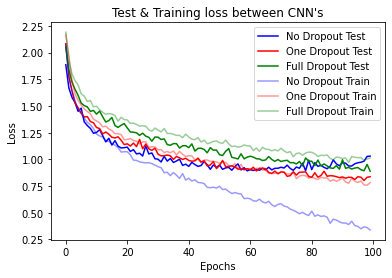

In [18]:
# Compares the test losses of the models with differnt dropouts
No_drop_test,   = plt.plot(model21_info[1], color = "b", label = "No Dropout Test")
One_drop_test,  = plt.plot(model22_info[1], color = "r", label = "One Dropout Test")
Full_drop_test, = plt.plot(model23_info[1], color = "g", label = "Full Dropout Test")

No_drop_train,  = plt.plot(training_history_lst(model21_info, "loss"), color = "b", label = "No Dropout Test", alpha = 0.4)
One_drop_train, = plt.plot(training_history_lst(model22_info, "loss"), color = "r", label = "One Dropout Test", alpha = 0.4)
Full_drop_train,= plt.plot(training_history_lst(model23_info, "loss"), color = "g", label = "Full Dropout Test", alpha = 0.4)

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Test & Training loss between CNN's")
plt.legend([No_drop_test, One_drop_test, Full_drop_test, No_drop_train, One_drop_train, Full_drop_train], 
           ["No Dropout Test", "One Dropout Test", "Full Dropout Test", "No Dropout Train", "One Dropout Train", "Full Dropout Train"])
plt.show()

---
---

Training loss rates vs. test loss rates:

One can observe that the training loss rate diverges significatly below the testing loss rate for the 'No Dropout' CNN after epoch 20. Further, the training loss of the 'No Dropout' CNN does not appear to converge to a single value in comparision to the 'One Dropout' and 'Full Dropout' CNN. The behaviour of 'No Dropout' CNN is as expected in the absense of any regulisation (such as dropouts). As the 'No Dropout' CNN becomes more and more fitted to the training data, training loss rates will consistently diverge below testing loss rates. 

However, as the degree of regulisation (number of dropouts) in the CNN increases, the training loss rates become greater than the corroponding test loss rates. 

Similarly, this phenomenon can be attributed to the regulisation imposed on the CNN by the addition of dropouts as these add 'bias' to the CNN, reducing the tendency of the CNN to overfit the training data. Greater 'bias' reduces the ability of the CNN to fit the training data as 'accuratly' as possible. Consequently, it is posisble that if enough bias is added to the CNN, the training loss rates will be greater than the testing loss rates.   

---
---

Comparison between models and the benefits of dropout:


Another observation made from the above graph is that adding dropouts can reduce the testing loss rates of a CNN by limiting overfitting. The 'No Dropout' testing loss rate starts to increase at ~60 epochs. This suggests that the 'No Dropout' CNN becomes overfitted and thus the classification abilities of the model reduce. The testing loss rates for the 'No Dropout' CNN eventually become larger than those of the 'One Dropout' and 'Full Dropout' CNN. Consequently, adding dropouts to a CNN can improve classification ability by limiting overfitting. 

However, there is a trade-off between the number of dropout layers in the CNN and it's performace. In the above example, the 'One Dropout' CNN produces lower testing loss rates than the 'Full Dropout' CNN, although both produce lower testing loss rates than the 'No Dropout' CNN. 

## P3. CIFAR10 image classification

Design and implement a convolutional neural network for the CIFAR10 image classification task aiming to achieve a high test accuracy. Evaluate the classification accuracy by reporting top-1 and top-5 test error rates. 

**Task:** Plot the loss function, top-1 error rate and top-5 error rate per epoch versus the number of epochs for the training and the test dataset. 
Make sure to well describe and justify your network architecture design choices. 

In [21]:
# Problem 3 paramters
filters_p3      = 30
regulization_p3 = 1e-4


In [23]:
model31 = tf.keras.Sequential([
          tf.keras.layers.Conv2D(filters_p3, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(regulization_p3), activation="relu", input_shape = (32,32,3)),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Conv2D(filters_p3, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(regulization_p3), activation="relu"),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Conv2D(filters_p3, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(regulization_p3), activation="relu"),
          tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
          tf.keras.layers.Dropout(0.3),
          
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Conv2D(filters_p3*3, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(regulization_p3), activation="relu"),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Conv2D(filters_p3*3, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(regulization_p3), activation="relu"),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Conv2D(filters_p3*3, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(regulization_p3), activation="relu"),
          tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
          tf.keras.layers.Dropout(0.3),

          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Conv2D(filters_p3*4, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(regulization_p3), activation="relu"),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Conv2D(filters_p3*4, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(regulization_p3), activation="relu"),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Conv2D(filters_p3*4, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(regulization_p3), activation="relu"),
          tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
          tf.keras.layers.Dropout(0.3),

          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(10, activation = "softmax"),
])

model31.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=metrics)
model31.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 30)        840       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 30)        120       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 30)        8130      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 30)        120       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 30)        8130      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 30)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 30)       

Model Architecture:

---
---

In comparison to the model acitecture from problem 2 the above model was modified to increase the depth of the CNN and reduce the convolutional filter dimensions such that smaller details would be captured. Moreover, in addition to dropouts, further regulisation was added to the model in the form of batch normalisation and L2 regulisation.   

The above model consists of 3 'layers', each of which consist of 3 convolutional filters + batch normalisation, followed by a max pooling layer and a dropout layer. There does not exisit a fully hidden layer of nurons between the flatten layer and the final classification layer. Due to the added number of convolutional filters, a fully hidden layer was not incorporated into the model as this increased the number of trainable parameters significantly, subsequently resulting in model overfitting. Models with fewer filters and a hidden layer were evaluated, however, they produced higher testing loss rates versus the model outlined above. 

Batch Normalisation and L2 regulisation was incorporatred into the arcitecture to reduce overfitting (beyond additional dropouts).

In [24]:
model31_info    = training(model31)
# Similar training methodology was used as in problem 2 to aid comparision
# between models already trained and evaluated

*** Epoch: 0 ***
50/50 [==============================] - 58s 1s/step - loss: 2.4220 - accuracy: 0.2702 - sparse_top_k_categorical_accuracy: 0.8734
Test accuracy: 0.09656249731779099
__________
*** Epoch: 1 ***
50/50 [==============================] - 55s 1s/step - loss: 1.8618 - accuracy: 0.3702 - sparse_top_k_categorical_accuracy: 0.8794
Test accuracy: 0.10921874642372131
__________
*** Epoch: 2 ***
50/50 [==============================] - 55s 1s/step - loss: 1.6607 - accuracy: 0.4344 - sparse_top_k_categorical_accuracy: 0.9067
Test accuracy: 0.10171875357627869
__________
*** Epoch: 3 ***
50/50 [==============================] - 55s 1s/step - loss: 1.5431 - accuracy: 0.4706 - sparse_top_k_categorical_accuracy: 0.9266
Test accuracy: 0.11890625208616257
__________
*** Epoch: 4 ***
50/50 [==============================] - 55s 1s/step - loss: 1.4728 - accuracy: 0.4995 - sparse_top_k_categorical_accuracy: 0.9239
Test accuracy: 0.12609374523162842
__________
*** Epoch: 5 ***
50/50 [======

50/50 [==============================] - 55s 1s/step - loss: 0.5304 - accuracy: 0.8612 - sparse_top_k_categorical_accuracy: 0.9953
Test accuracy: 0.796093761920929
__________
*** Epoch: 85 ***
50/50 [==============================] - 54s 1s/step - loss: 0.5232 - accuracy: 0.8636 - sparse_top_k_categorical_accuracy: 0.9964
Test accuracy: 0.8196874856948853
__________
*** Epoch: 86 ***
50/50 [==============================] - 54s 1s/step - loss: 0.5062 - accuracy: 0.8712 - sparse_top_k_categorical_accuracy: 0.9964
Test accuracy: 0.8329687714576721
__________
*** Epoch: 87 ***
50/50 [==============================] - 54s 1s/step - loss: 0.5193 - accuracy: 0.8697 - sparse_top_k_categorical_accuracy: 0.9959
Test accuracy: 0.8162500262260437
__________
*** Epoch: 88 ***
50/50 [==============================] - 53s 1s/step - loss: 0.5318 - accuracy: 0.8580 - sparse_top_k_categorical_accuracy: 0.9962
Test accuracy: 0.8229687213897705
__________
*** Epoch: 89 ***
50/50 [========================

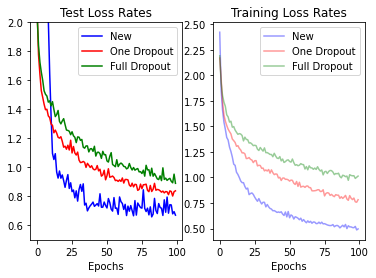

In [25]:
# Loss Rates
plt.subplot(1,2,2)
model_31,   = plt.plot(training_history_lst(model31_info, "loss"), color = "b", alpha = 0.4)
model_22,   = plt.plot(training_history_lst(model22_info, "loss"), color = "r", alpha = 0.4)
model_23,   = plt.plot(training_history_lst(model23_info, "loss"), color = "g", alpha = 0.4)
plt.legend([model_31, model_22, model_23], ["New", "One Dropout", "Full Dropout"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Rates")

plt.subplot(1,2,1)
model_31,   = plt.plot(model31_info[1], color = "b")
model_22,   = plt.plot(model22_info[1], color = "r")
model_23,   = plt.plot(model23_info[1], color = "g")
plt.legend([model_31, model_22, model_23], ["New", "One Dropout", "Full Dropout"])
plt.xlabel("Epochs")
plt.ylim((0.5,2))
plt.title("Test Loss Rates")

plt.show()

Loss Rates Comparision:
We begin seeing a lower test rate for the new model. While generally lower across all epochs, we can see the new model's loss has a higher variance.

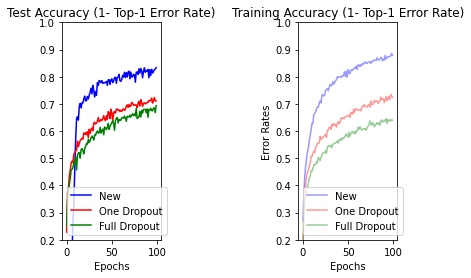

In [35]:
# Top-1 Error Rates
plt.subplot(1,3,3)
model_31,   = plt.plot(training_history_lst(model31_info, "accuracy"), color = "b", alpha = 0.4)
model_22,   = plt.plot(training_history_lst(model22_info, "accuracy"), color = "r", alpha = 0.4)
model_23,   = plt.plot(training_history_lst(model23_info, "accuracy"), color = "g", alpha = 0.4)
plt.legend([model_31, model_22, model_23], ["New", "One Dropout", "Full Dropout"])
plt.xlabel("Epochs")
plt.ylabel("Error Rates")
plt.title("Training Accuracy (1- Top-1 Error Rate)")
plt.ylim((0.2,1))

plt.subplot(1,3,1)
model_31,   = plt.plot(model31_info[2], color = "b")
model_22,   = plt.plot(model22_info[2], color = "r")
model_23,   = plt.plot(model23_info[2], color = "g")
plt.legend([model_31, model_22, model_23], ["New", "One Dropout", "Full Dropout"])
plt.xlabel("Epochs")
plt.title("Test Accuracy (1- Top-1 Error Rate)")
plt.ylim((0.2,1))

plt.show()

From the above graph, it is evident that the new model has superior Top-1 error rates relative to the 'One Dropout' and 'Full Dropout' CNN's used in problem 2 after 100 epochs. Although the training error rates are similar for the 3 models in the early epochs, the 'One Dropout' and 'Full Dropout' CNN's have higher testing loss rates below epoch ~10. 

After 100 epochs, the training and testing error rates appear to converge to a steady level (~88% training accuracy and ~83% test accuracy for the 'New' CNN). However, the testing error rates are more variable than training error rates.

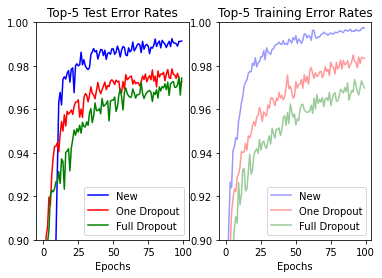

In [27]:
# Top-5 Error Rates
plt.subplot(1,2,2)
model_31,   = plt.plot(training_history_lst(model31_info), color = "b", alpha = 0.4)
model_22,   = plt.plot(training_history_lst(model22_info), color = "r", alpha = 0.4)
model_23,   = plt.plot(training_history_lst(model23_info), color = "g", alpha = 0.4)
plt.legend([model_31, model_22, model_23], ["New", "One Dropout", "Full Dropout"])
plt.xlabel("Epochs")
plt.ylabel("Error Rates")
plt.title("Top-5 Training Error Rates")
plt.ylim((0.9,1))

plt.subplot(1,2,1)
model_31,   = plt.plot(model31_info[3], color = "b")
model_22,   = plt.plot(model21_info[3], color = "r")
model_23,   = plt.plot(model23_info[3], color = "g")
plt.legend([model_31, model_22, model_23], ["New", "One Dropout", "Full Dropout"])
plt.xlabel("Epochs")
plt.title("Top-5 Test Error Rates")
plt.ylim((0.9,1))

plt.show()

Similarly to the top-1 error rates, it is evident that the 'New' CNN has superior Top-5 error rates relative to the 'One Dropout' and 'Full Dropout' CNN's after 100 epochs. Although the training error rates are similar for the 3 models in the early epochs, the 'One Dropout' and 'Full Dropout' CNN's have superior testing loss rates below epoch ~10. 

After 100 epochs, the training and testing error rates appear to converge to a steady level (~99% Top-5 training accuracy and ~95% Top-5 test accuracy for the 'New' CNN). However, the testing error rates are more variable than training error rates. The variablitiy in the testing error rates may be attributable to the degree of dropout in the model as the 'Full Dropout' and the 'New' CNN show more variability around the 50 epochs mark relative to the 'One Dropout' CNN. 